In [1]:
%pip install pyspark



  Using cached pyspark-3.5.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Note: you may need to restart the kernel to use updated packages.


## Importing libraries and reading the dataset

In [2]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext

import pyspark
from pyspark.sql import SparkSession

if __name__ == "__main__":
    spark = SparkSession.builder.appName("Detecting-Malicious-URL App").getOrCreate()

    # Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='/Users/srihithprudhivi95/Documents/CSE412/BDLC Assn2/dataset.csv',
                             sep=',',
                             encoding='UTF-8',
                             comment=None,
                             header=True,
                             inferSchema=True)

data_df.groupby('label').count().toPandas()



23/11/26 17:29:29 WARN Utils: Your hostname, Srihiths-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.16.197.89 instead (on interface en0)
23/11/26 17:29:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/26 17:29:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,label,count
0,1,56937
1,0,1000000


## Under sampling the unbalanced data

In [3]:
malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,54103


## Data Ingestion and Vectorization

In [4]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 88898


Test Dataset Count: 22142
Total Dataset Count: 111040
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6979,[0,1,2,3,19...|(6979,[0,1,2,3,19...|
|https://semana-da...|    1|[https, semana, d...|(6979,[0,3,6,19,2...|(6979,[0,3,6,19,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6979,[0,6,843],[...|(6979,[0,6,843],[...|
|http://my-softban...|    1|[http, my, softba...|(6979,[0,1,29,164...|(6979,[0,1,29,164...|
|http://www.my-sof...|    1|[http, www, my, s...|(6979,[0,1,4,29,1...|(6979,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45609
1,0,43289


## Naive Bayes Classifier

Test: Area Under ROC: 0.968696188190868


23/11/26 17:29:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


True Positives: 10844
True Negative: 10599
False Positive: 215
False Negative: 484
Total: 22142
F-Score: 96.8776521

Accuracy: 96.8431
Recall: 95.7274
Precision: 98.0559


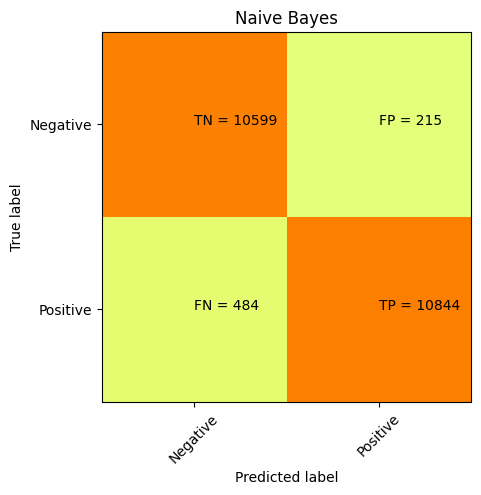

In [6]:
# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial",)

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)


# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#===========================
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


#===========================ploting

#plt.clf()
nb_predictions = model.transform(testData)

y_actu = nb_predictions.select("label").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
        
plt.show()

## Logistic Regression



23/11/26 17:29:51 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/26 17:29:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS



True Positives: 10717
True Negative: 10810
False Positive: 4
False Negative: 611
Total: 22142

Accuracy: 97.2225
F-Score: 97.2107581
Recall: 94.6063
Precision: 99.9627


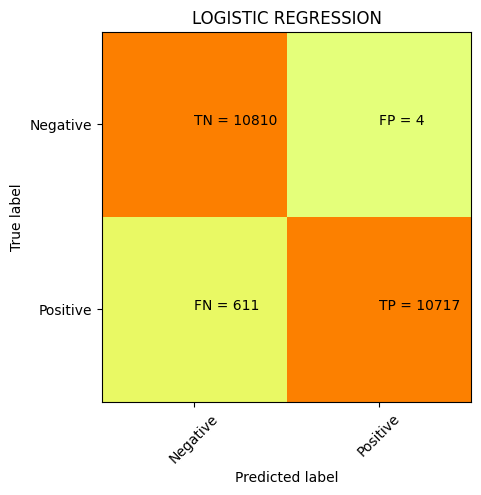

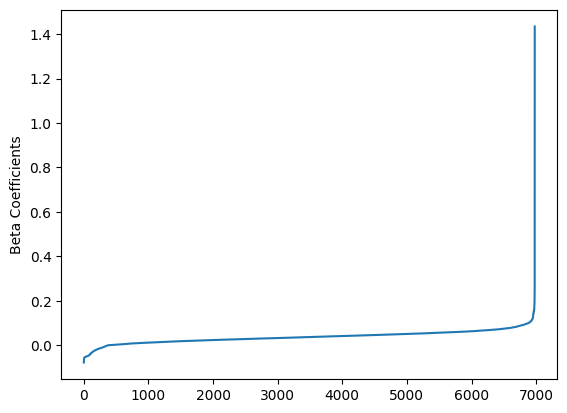

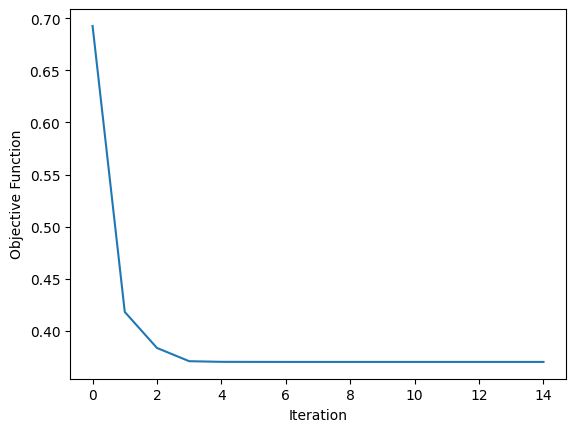

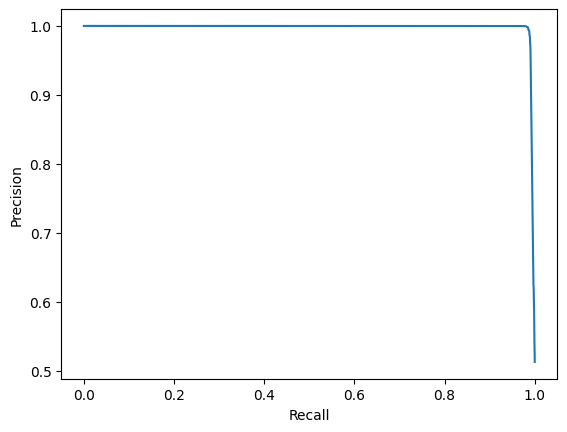

areaUnderROC: 0.995688400796767


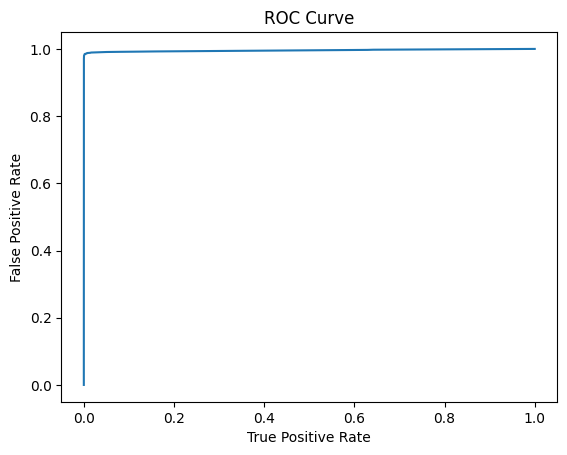

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9988945698...|0.0012270745...|
|0.9981154318...|0.0024526442...|
|0.9972650361...|0.0056844268...|
|0.9964429411...|0.0082536355...|
|0.9957274354...|0.0093837290...|
|0.9950979551...|0.0107294733...|
|0.9940905074...|0.0119867491...|
|0.9933778848...|0.0131991636...|
|0.9926397283...|0.0144533205...|
|0.9921385551...|0.0155763917...|
+---------------+---------------+
only showing top 10 rows



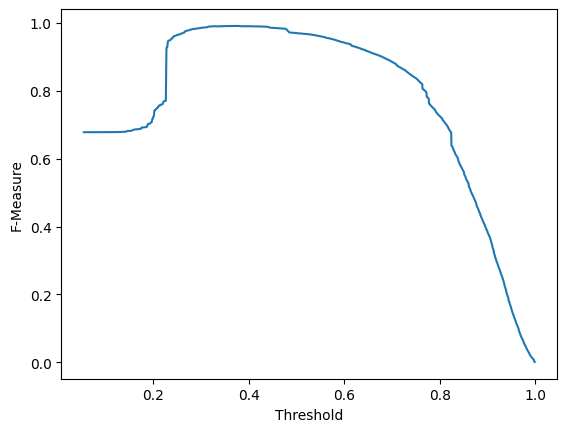

+----------------------------------------+-----+----------+
|                                     url|label|prediction|
+----------------------------------------+-----+----------+
|          buy-cheapest-price-viagra.mobi|    0|       0.0|
|             20mg-vardenafil-levitra.org|    0|       0.0|
|                   viagra-buy-100mg.info|    0|       0.0|
|                party-london-girls.co.uk|    0|       0.0|
|   prednisone-online-no-prescription.org|    0|       0.0|
|  no-prescription-pharmacy-canadian.site|    0|       0.0|
|                     cialis20mg-5mg.mobi|    0|       0.0|
|                cheapest-cialis20mg.mobi|    0|       0.0|
|                   nike-outlet-store.com|    0|       0.0|
|                         cheap-viagra.tv|    0|       0.0|
|                   hitachi-medical.co.jp|    0|       0.0|
| 20mg-withoutprescription-prednisone.com|    0|       0.0|
|                    stuttgart-journal.de|    0|       0.0|
|                              pandora.n

In [7]:
#==============[ LOGISTIC REGRESSION ]=========================
r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0


# Build logistic regresssion model
for i in range(1,6):
    
    dataset = pipelineFit.transform(sampled)

    
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = lrModel.transform(testData)


df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))



#===========================ploting

#plt.clf()
lr_predictions = lrModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 25, truncate = 80)